In [1]:
import tensorflow as tf
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import h5py
import cv2 as cv
import random
import csv
import time
import string
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)


print(tf.__version__)
mnist = tf.keras.datasets.mnist

# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train, x_test = x_train, x_test 
# print(x_train.shape)




2.14.0


# Build Dataset

In [2]:
pth  = "H:\Datasets\\asl_ir"
names = [*string.ascii_uppercase] + ["others"]
id = list(range(len(names)))
fdict = dict(zip(names, id))
def dataset(pth, fdict, transform):
    labels = os.listdir(pth)
    labels_pth = [os.path.join(pth, i) for i in labels]
    samples_pth = []
    for i in labels_pth:
        samples = os.listdir(i)
        samples_pth += [os.path.join(i, j) for j in samples]
        
    labels = [fdict[i.split("\\")[3]] for i in samples_pth]

    # print(samples_pth)
    d_sl = dict(zip(samples_pth, labels))
    l_sl = list(d_sl.items())
    random.shuffle(l_sl)
    # print(len(l_sl))
    d_sl = dict(l_sl)
    samples_pth = list(d_sl.keys())
    labels = list(d_sl.values())

    
    features = []
    for sample in samples_pth:
        x = tf.io.read_file(sample)
        x = tf.image.decode_png(x, channels=1)
        # tf.print(x, summarize=-1)
        features.append(x)

    features = tf.convert_to_tensor(features)
    labels = tf.convert_to_tensor(labels)

    
    

    return features / 255, labels / 255
    
features, labels = dataset(pth, fdict, None)
features = tf.cast(features, dtype=tf.float32)
labels = tf.cast(labels, dtype=tf.int32)

print(features.shape)
    

(13577, 24, 32, 1)


In [3]:
checkpoint_path = "checkpoint\\asl_cnn.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)


In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(4, 3, 1, "same", use_bias=False, activation="relu", input_shape = (24, 32, 1)),
    tf.keras.layers.MaxPool2D((2, 2), 2, "valid"),
    tf.keras.layers.Conv2D(8, 3, 1, "same", use_bias=False, activation="relu", input_shape = (12, 16, 4)),
    tf.keras.layers.MaxPool2D((2, 2), 2, "valid"),
    tf.keras.layers.Flatten(input_shape=(6, 8, 8)),
    tf.keras.layers.Dense(29, use_bias=False)
])

In [5]:
features.shape
predictions = model(features[:1]).numpy()
predictions.shape

(1, 29)

In [6]:
tf.nn.softmax(predictions).numpy()

array([[0.03668215, 0.02609754, 0.05482464, 0.0316794 , 0.02074584,
        0.03317521, 0.02607555, 0.03307397, 0.07643749, 0.04232602,
        0.0342639 , 0.01356987, 0.04515065, 0.04674816, 0.03231414,
        0.0222114 , 0.04350029, 0.03320287, 0.03721156, 0.0568554 ,
        0.04067527, 0.02103482, 0.03268131, 0.03824433, 0.02794551,
        0.02238769, 0.03199641, 0.02333256, 0.01555608]], dtype=float32)

In [7]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [8]:
loss_fn(labels[:1], predictions).numpy()

3.3054652

In [9]:
model.compile(optimizer='adam',
            loss=loss_fn,
            metrics=['accuracy'])

In [10]:
model.fit(features, labels, batch_size=64,  epochs=100,  callbacks=[cp_callback])
model.evaluate(features,  labels, verbose=2)

Epoch 1/100
210/213 [============================>.] - ETA: 0s - loss: 0.2186 - accuracy: 0.9685
Epoch 1: saving model to checkpoint\asl_cnn.ckpt
213/213 [==============================] - 2s 6ms/step - loss: 0.2164 - accuracy: 0.9688
Epoch 2/100
208/213 [============================>.] - ETA: 0s - loss: 0.0054 - accuracy: 1.0000
Epoch 2: saving model to checkpoint\asl_cnn.ckpt
213/213 [==============================] - 1s 6ms/step - loss: 0.0053 - accuracy: 1.0000
Epoch 3/100
212/213 [============================>.] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000
Epoch 3: saving model to checkpoint\asl_cnn.ckpt
213/213 [==============================] - 1s 7ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 4/100
208/213 [============================>.] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000
Epoch 4: saving model to checkpoint\asl_cnn.ckpt
213/213 [==============================] - 2s 8ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 5/100
212/213 [============================>.] - ETA: 

[0.0006061607855372131, 1.0]

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Lambe\AppData\Local\Temp\tmp9n355u3y\assets


INFO:tensorflow:Assets written to: C:\Users\Lambe\AppData\Local\Temp\tmp9n355u3y\assets


In [12]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Lambe\AppData\Local\Temp\tmpqwwefsoh\assets


INFO:tensorflow:Assets written to: C:\Users\Lambe\AppData\Local\Temp\tmpqwwefsoh\assets


In [13]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(features).batch(1).take(1000):
    # Model has only one input so each data point has one element.
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Lambe\AppData\Local\Temp\tmple1d_hwd\assets


INFO:tensorflow:Assets written to: C:\Users\Lambe\AppData\Local\Temp\tmple1d_hwd\assets
d:\Anaconda\anaconda3\envs\Flow\lib\site-packages\tensorflow\lite\python\convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [14]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


In [15]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(features).batch(64).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Lambe\AppData\Local\Temp\tmpkfcf0vi1\assets


INFO:tensorflow:Assets written to: C:\Users\Lambe\AppData\Local\Temp\tmpkfcf0vi1\assets
d:\Anaconda\anaconda3\envs\Flow\lib\site-packages\tensorflow\lite\python\convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [16]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [17]:
import pathlib

tflite_models_dir = pathlib.Path("H:\\tensorflow\\tmp\\asl_tflite_models")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"asl_model.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"asl_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

15040

In [18]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
    global features

    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_image_indices),), dtype=int)
    for i, test_image_index in enumerate(test_image_indices):
        feature = features[test_image_index]
        label = labels[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
        input_scale, input_zero_point = input_details["quantization"]
        feature = feature / input_scale + input_zero_point

    feature = np.expand_dims(feature, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], feature)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

    return predictions

In [19]:
import matplotlib.pylab as plt

# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, idx, model_type):
    global labels

    predictions = run_tflite_model(tflite_file, [idx])

    plt.imshow(features[idx])
    template = model_type + " Model \n True:{true}, Predicted:{predict}"
    _ = plt.title(template.format(true= str(labels[idx]), predict=str(predictions[0])))
    plt.grid(False)

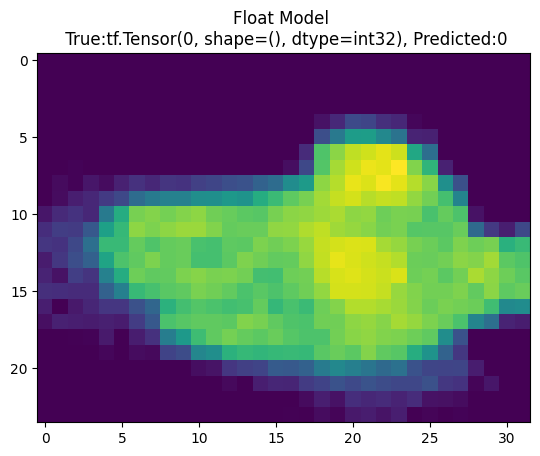

In [20]:
test_model(tflite_model_file, test_image_index, model_type="Float")

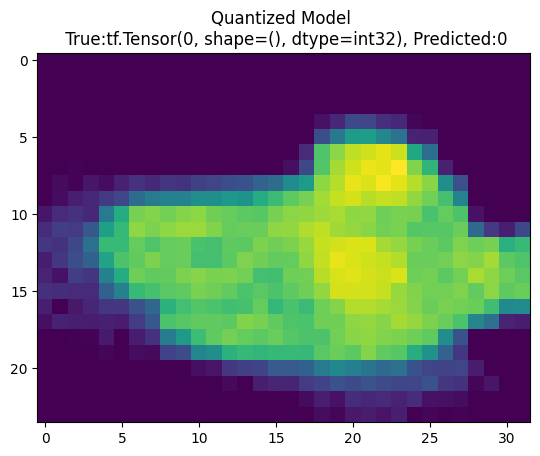

In [21]:
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

In [22]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
    global features
    global features

    test_image_indices = range(features.shape[0])
    predictions = run_tflite_model(tflite_file, test_image_indices)
    accuracy = (np.sum(labels== predictions) * 100) / len(features)
    print(labels)
    print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
        model_type, accuracy, len(features)))
    # print(labels, predictions)

In [23]:
evaluate_model(tflite_model_file, model_type="Float")

tf.Tensor([0 0 0 ... 0 0 0], shape=(13577,), dtype=int32)
Float model accuracy is 100.0000% (Number of test samples=13577)


In [24]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

tf.Tensor([0 0 0 ... 0 0 0], shape=(13577,), dtype=int32)
Quantized model accuracy is 100.0000% (Number of test samples=13577)
